In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
df = pd.read_csv("../../data/selected_dataset.csv")
df.head()

,chunk_id,developerdecision,kind_conflict,url,project,project_user,project_name,path,file_name,sha,...,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
0,777206,ConcatenationV2V1,"Attribute, Comment, Method invocation",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,2d88e89330552363f1d2af979ac3ebf232a91fb3,...,13.0,1.0,14.0,1.0,1.0,85.0,1.0,313.0,2.0,1.0
1,777207,Version 1,"Comment, Method declaration",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,2d5c6e5d12d784bd7538eb5aab421691ce4c688d,...,8.0,3.0,11.0,2.0,1.0,9.0,25.0,25.0,108.0,1.0
2,777216,Combination,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,f32b758df664833130d5d75006a09df0fae43d71,...,2.0,4.0,6.0,1.0,1.0,3.0,32.0,5.0,94.0,1.0
3,777218,Combination,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,f32b758df664833130d5d75006a09df0fae43d71,...,2.0,4.0,6.0,1.0,1.0,3.0,32.0,5.0,94.0,1.0
4,777221,Version 1,"Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/libanki/Me...,Media.java,59973c74b19c37712c469bdafbdb10cc665d7b93,...,1.0,3.0,4.0,0.0,0.0,2.0,29.0,5.0,276.0,1.0


In [3]:
total_chunks = len(df)
total_projects = len(pd.unique(df['project']))
total_merges = len(pd.unique(df['sha']))
print(f"The dataset has {total_merges} merges with {total_chunks} chunks from {total_projects} projects.")

The dataset has 7955 merges with 86215 chunks from 78 projects.


In [3]:
df.describe()

,chunk_id,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,...,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
count,1.758050e+05,1.448720e+05,1.448720e+05,1.448720e+05,1.448720e+05,138186.000000,144872.000000,144872.000000,144872.000000,144872.000000,...,154962.000000,154962.000000,154962.000000,154962.000000,154962.000000,154962.000000,154962.000000,154962.000000,154962.000000,154962.000000
mean,1.142893e+06,6.786178e+03,2.820940e+04,2.777475e+04,3.518419e+04,23.730617,88.501277,41.239032,3.908816,7.696318,...,17.657381,3.604826,21.262206,1.784779,0.807611,353.941321,109.663356,935.580904,352.409817,0.988294
std,2.142323e+05,6.261432e+04,2.218461e+05,2.772720e+05,1.214814e+05,128.559045,305.229239,233.682629,16.851995,24.934574,...,44.208164,6.212715,44.755817,4.531142,0.585164,869.551659,410.773771,2031.047008,704.812183,0.173167
min,7.766610e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.789890e+05,1.800000e+01,7.700000e+01,1.000000e+02,3.430000e+02,0.000000,3.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,3.000000,0.000000,0.000000,8.000000,1.000000,44.000000,15.000000,1.000000
50%,1.122765e+06,1.770000e+02,8.920000e+02,1.397000e+03,3.198000e+03,1.000000,11.000000,2.000000,0.000000,1.000000,...,2.000000,1.000000,5.000000,1.000000,1.000000,52.000000,6.000000,273.000000,59.000000,1.000000
75%,1.348489e+06,1.770000e+03,4.623250e+03,1.243050e+04,2.730400e+04,14.000000,55.000000,9.000000,2.000000,5.000000,...,8.000000,4.000000,15.000000,1.000000,1.000000,202.000000,49.000000,1273.000000,349.000000,1.000000
max,1.658686e+06,2.459541e+06,2.695464e+06,1.644547e+07,2.696357e+06,2211.000000,9194.000000,6668.000000,408.000000,399.000000,...,476.000000,192.000000,477.000000,180.000000,2.000000,12134.000000,7740.000000,92023.000000,31270.000000,2.000000


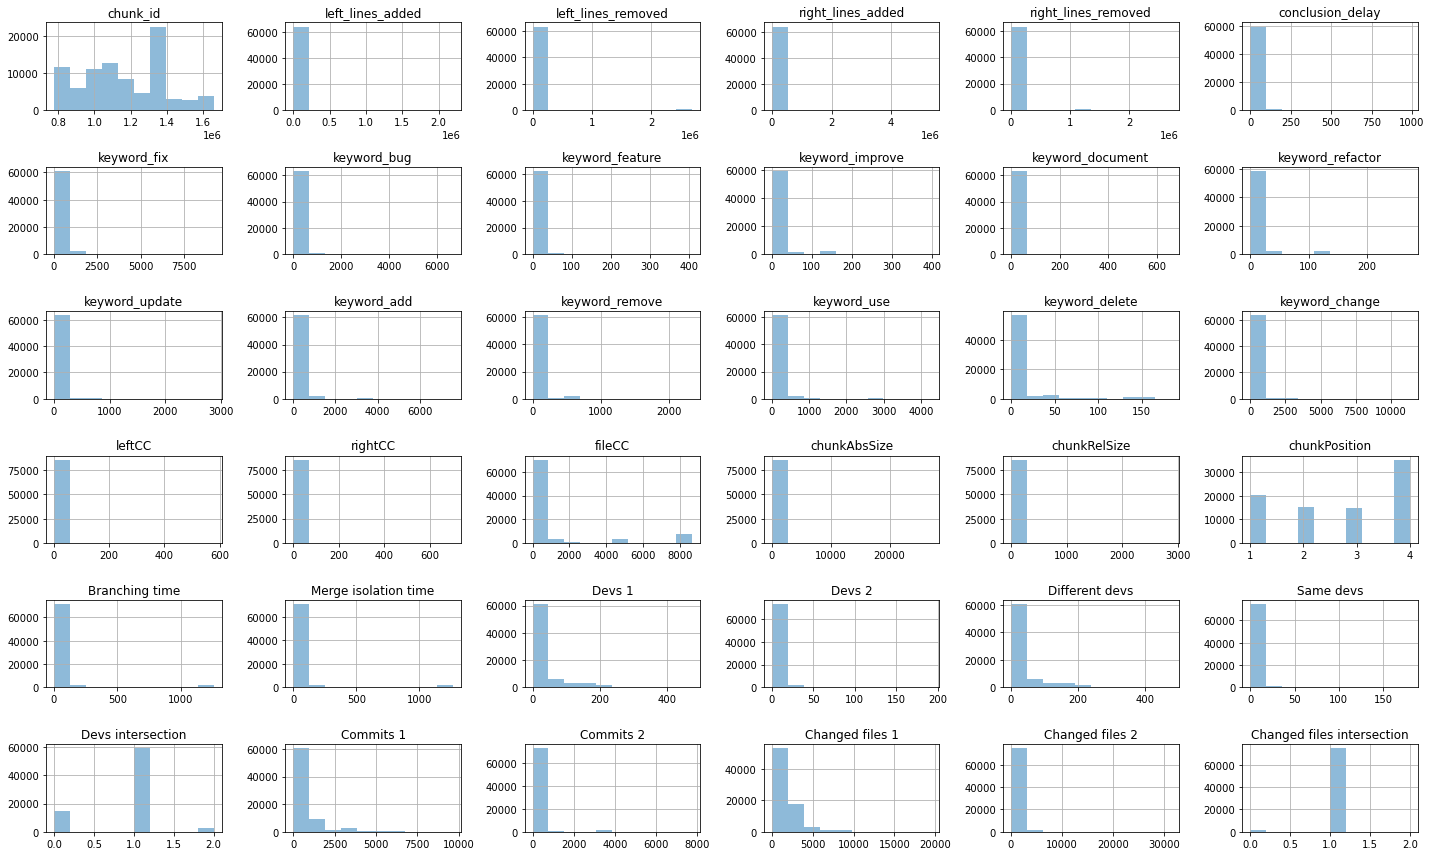

In [41]:
df.hist(alpha=0.5, figsize=(20, 12))
plt.tight_layout()
plt.show()

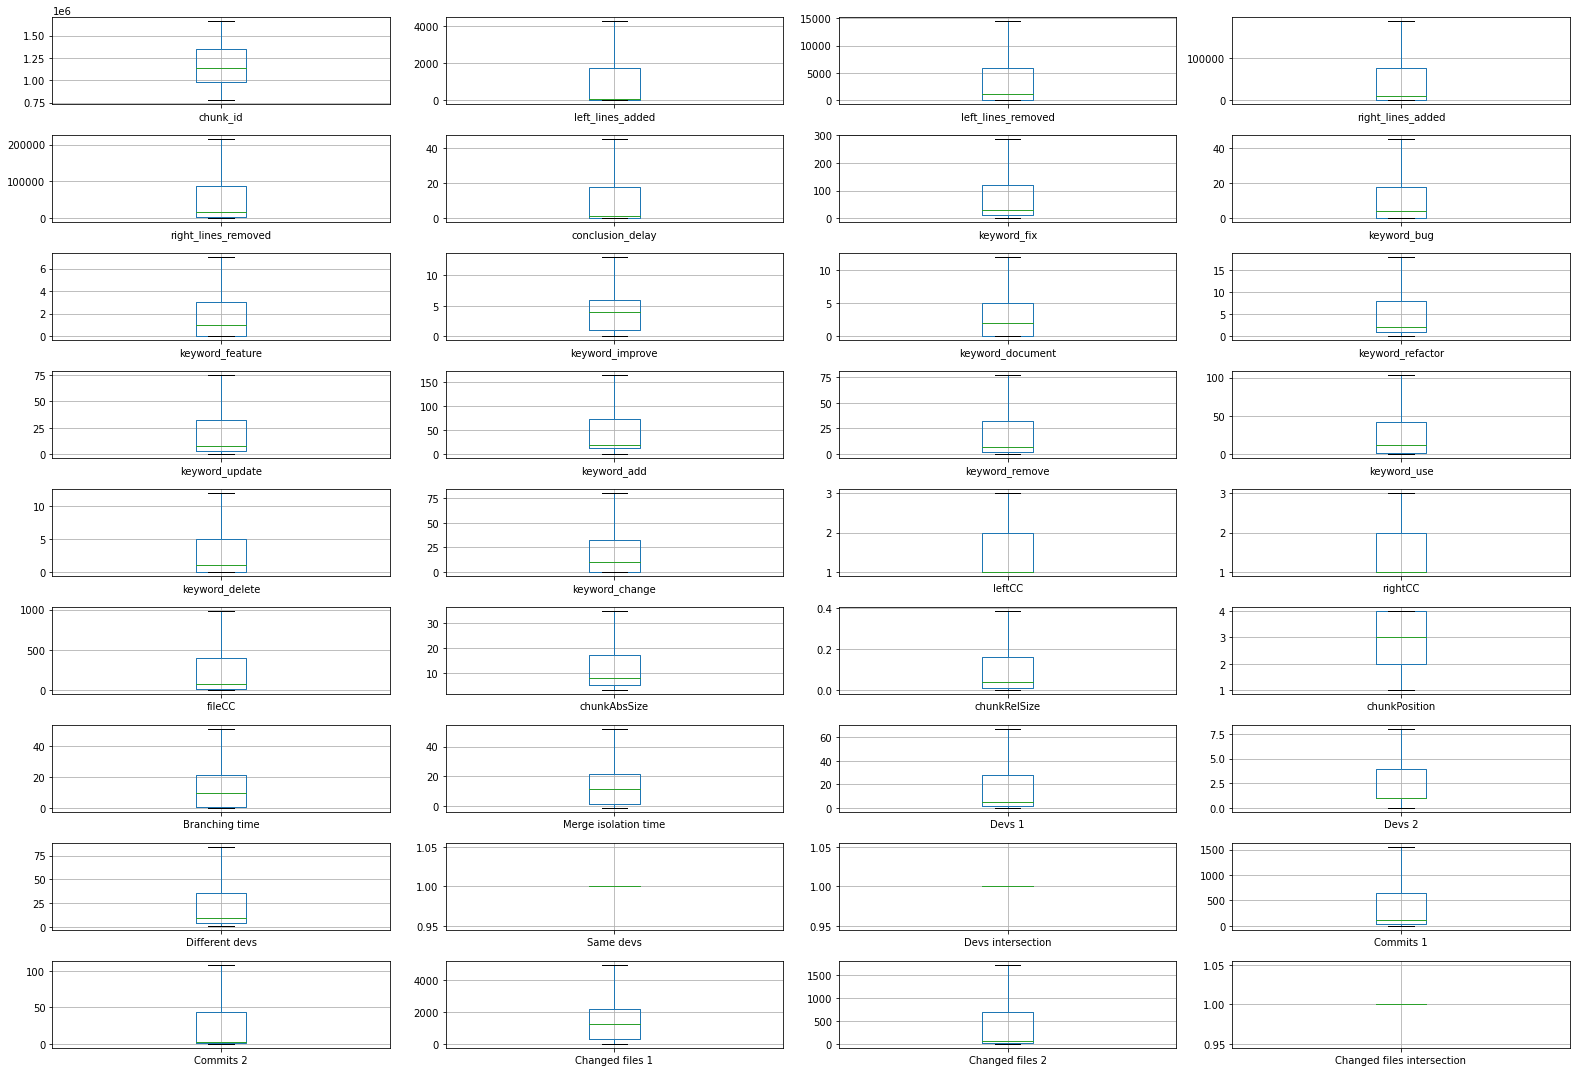

In [72]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
i = j = 0
cols = 4
rows = 9
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(22,15))
for column in df.select_dtypes(include=numerics):
    df.boxplot(column=column, ax=axes[i][j], showfliers=False) # add boxplot to 1st subplot
    if j == cols-1:
        j = 0
        i+=1
    else:
        j+=1
plt.tight_layout()
plt.show()

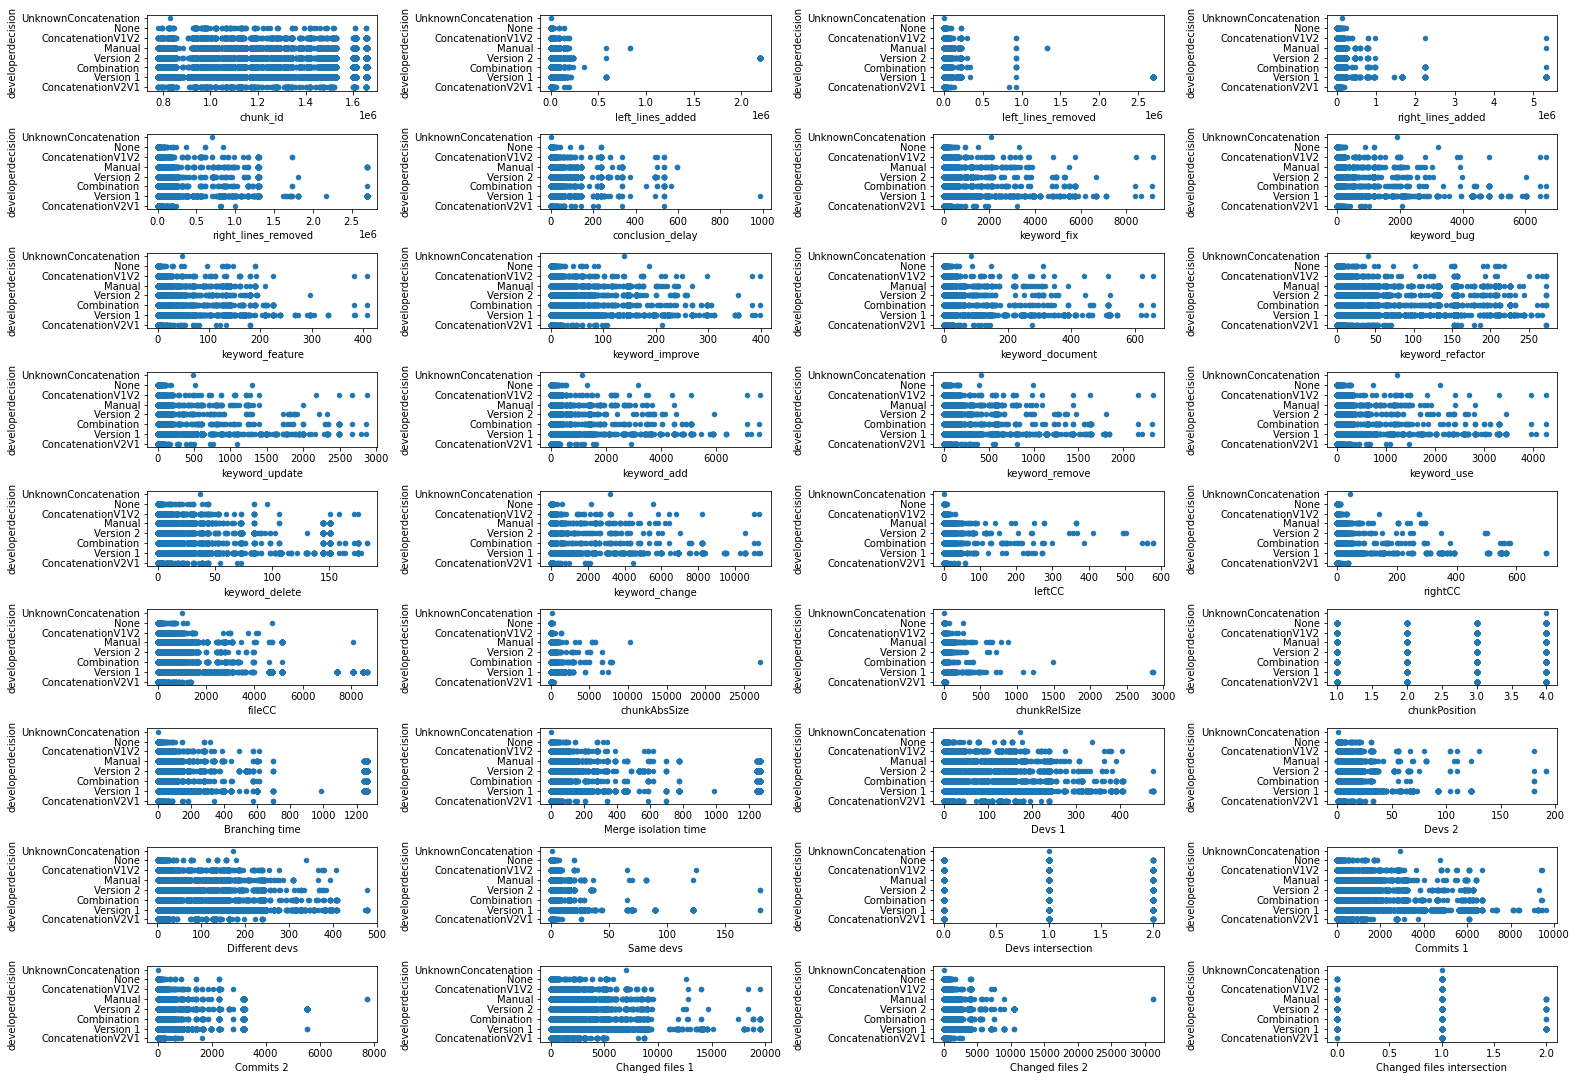

In [74]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
i = j = 0
cols = 4
rows = 9
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(22,15))
for column in df.select_dtypes(include=numerics):
#     df.plot.scatter(x="a", y="b");
    df.plot.scatter(x=column, y='developerdecision', ax=axes[i][j]) # add boxplot to 1st subplot
    if j == cols-1:
        j = 0
        i+=1
    else:
        j+=1
plt.tight_layout()
plt.show()

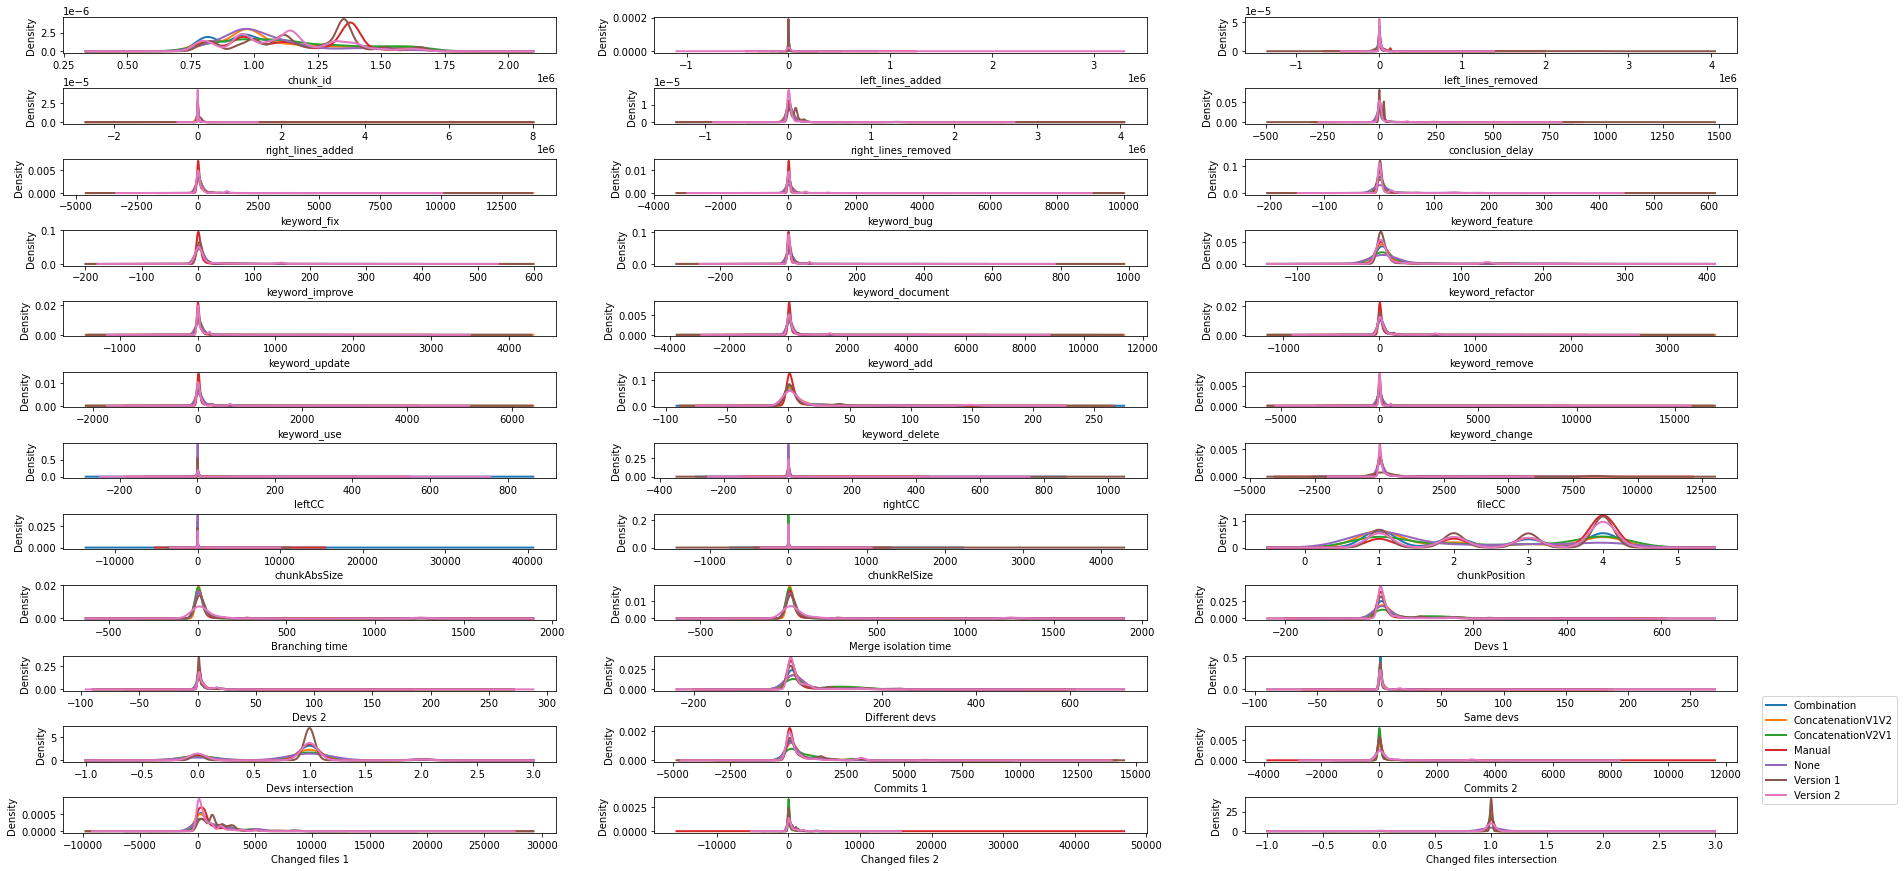

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
i = j = 0
cols = 3
rows = 12
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,15))
for column in df.select_dtypes(include=numerics):
    data_wide = df.pivot(columns='developerdecision',
                     values=column)
    data_wide = data_wide.drop(columns=['UnknownConcatenation'])
    data_wide.plot.density(linewidth = 2, legend=False, ax=axes[i][j])
    axes[i][j].set_xlabel(column)
#     plt.xlabel("left_lines_added")
#     df.plot.scatter(x=column, y='developerdecision', ax=axes[i][j]) # add boxplot to 1st subplot
    if j == cols-1:
        j = 0
        i+=1
    else:
        j+=1
# plt.tight_layout()
h, l = axes[0][0].get_legend_handles_labels()
plt.legend(h,l, loc=(1.05, 0.8))
fig.subplots_adjust(hspace=1)
plt.savefig('teste.png')
plt.show()

In [4]:
data_wide = df.pivot(columns='developerdecision',
                     values='fileCC')
data_wide.head()

developerdecision,Combination,ConcatenationV1V2,ConcatenationV2V1,Manual,None,UnknownConcatenation,Version 1,Version 2
0,NaN,NaN,533.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,527.0,NaN
2,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,99.0,NaN


In [ ]:
outliers_removed = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [ ]:
print(len(df))
print(len(outliers_removed))

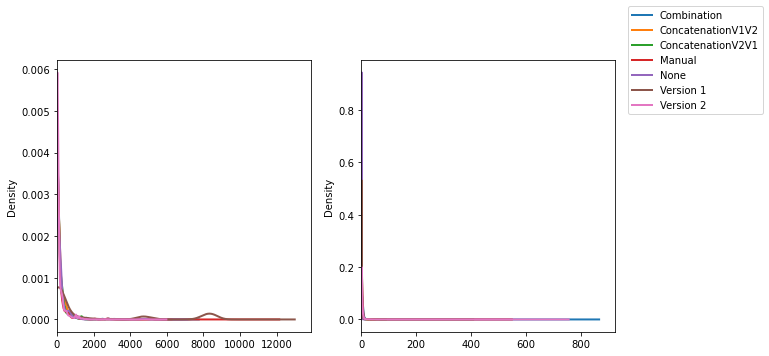

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
data_wide = df.pivot(columns='developerdecision',
                     values='fileCC')
data_wide = data_wide.drop(columns=['UnknownConcatenation'])
data_wide.plot.density(xlim=0,linewidth = 2, legend=False, ax=axes[0])
data_wide = df.pivot(columns='developerdecision',
                     values='leftCC')
data_wide = data_wide.drop(columns=['UnknownConcatenation'])
data_wide.plot.density(xlim=0,linewidth = 2, legend=False, ax=axes[1])
h, l = axes[0].get_legend_handles_labels()
plt.legend(h,l, loc=(1.05, 0.8))
plt.show()